In [1]:
%matplotlib inline
import numpy as np                   # advanced math library

# for reproducibility
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
rseed = np.random.RandomState(0)

import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

from keras.layers import Dense
from keras.models import Model
from keras.optimizers import adam_v2
from tensorflow.keras.callbacks import EarlyStopping


# import CNN tools
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.datasets import fashion_mnist


from sklearn.model_selection import train_test_split # some helper from scikit for data split

#get rid of annoying GPU warnings (and others)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
class_names = [
 "T-shirt/top",
 "Trouser",
 "Pullover",
 "Dress",
 "Coat",
 "Sandal",
 "Shirt",
 "Sneaker",
 "Bag",
 "Ankle boot"    
]

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("------------------------------\n")
print(f"X_train's shape is {X_train.shape}")
print(f"y_train's shape is {y_train.shape}")
print(f"X_test's shape is {X_test.shape}")
print(f"y_test's shape is {y_test.shape}")
print(f"y_train has {np.max(y_train) + 1} classes")


4431872/4422102 [==============================] - 1s 0us/step
------------------------------

X_train's shape is (60000, 28, 28)
y_train's shape is (60000,)
X_test's shape is (10000, 28, 28)
y_test's shape is (10000,)
y_train has 10 classes


In [3]:
# We want to add channels to our X data, so that they
# are compatible with the Convolutional Layers

# The idea here is that we are working in greyscale
# So the image has 1 channel

# The image data is of shape (N, im_height, im_width, channels)
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

print(X_train.shape)
print(X_test.shape)
print(f"The maximum value of X_train is {np.max(X_train)}. We don't want this, because it'll make training longer")

X_train = X_train / 255
X_test = X_test / 255

print(f"Now the maximum value of X_train is {np.max(X_train)}. We have now scaled our training data.")

(60000, 28, 28, 1)
(10000, 28, 28, 1)
The maximum value of X_train is 255. We don't want this, because it'll make training longer
Now the maximum value of X_train is 1.0. We have now scaled our training data.


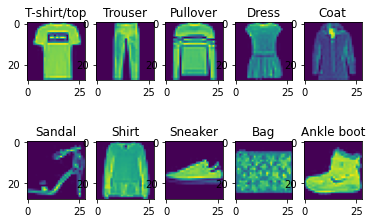

In [4]:
# Let's take a look at some of these images

fig, ax = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        ind = (i * 5) + j
        ds_ex = np.where(y_train == ind)[0][0]        
        ax[i, j].imshow(X_train[ds_ex, ...])
        ax[i, j].set_title(class_names[ind])
plt.show()

In [5]:
def to_one_hot(y):
    """
    Input: y of shape (n_samples)
    Output: y of shape (n_samples, n_classes)
    """
    onehot = np.zeros((y.shape[0], len(class_names)))
    onehot[np.arange(y.shape[0]), y] = 1
#     for i in range(len(y)):
#         onehot[i, y[i]] = 1
    return onehot

In [6]:
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

print(f"y_test's shape is {y_test.shape}")
print(f"y_train's shape is {y_train.shape}")

y_test's shape is (10000, 10)
y_train's shape is (60000, 10)


Aim:
- Split the training data into train:validation split of 80:20
- Train using training data but by evaluating the validation set
- Maximize accuracy on the unseen test set

In [7]:
# Split the training data into train:validation split of 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rseed)

print("New shapes\n")
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

New shapes

X_train shape (48000, 28, 28, 1)
y_train shape (48000, 10)
X_val shape (12000, 28, 28, 1)
y_val shape (12000, 10)
X_test shape (10000, 28, 28, 1)
y_test shape (10000, 10)


In [8]:
#Train using training data but by evaluating the validation set

#this is the model I will be using
model= Sequential()

# Below I will start defining my Convolution Layers- the inputs are already shaped to accomodate
# 2D convolutions in Keras

# Convolution Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3),padding='same',strides=(1, 1), input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))


# Convolution Layer 2
model.add(Conv2D(filters=32, strides=(1, 1),padding='same', kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2))) 


# Convolution Layer 3
model.add(Conv2D(filters=64, kernel_size=(2,2)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Flatten())  
                                                     # Output (Softmax Activation) Layer
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0

In [10]:
# we'll use this optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# we will also perform this in batch
batch_sz = 128
num_epochs = 12

model.fit(X_train, y_train, 
          batch_size=batch_sz, 
          epochs=num_epochs, 
          validation_data=(X_val, y_val), verbose=1)

Epoch 1/12
375/375 [==============================] - 13s 10ms/step - loss: 0.4412 - accuracy: 0.8449 - val_loss: 1.5473 - val_accuracy: 0.5622
Epoch 2/12
375/375 [==============================] - 3s 8ms/step - loss: 0.2871 - accuracy: 0.8961 - val_loss: 0.3241 - val_accuracy: 0.8838
Epoch 3/12
375/375 [==============================] - 3s 8ms/step - loss: 0.2444 - accuracy: 0.9126 - val_loss: 0.3218 - val_accuracy: 0.8951
Epoch 4/12
375/375 [==============================] - 3s 8ms/step - loss: 0.2263 - accuracy: 0.9186 - val_loss: 0.2943 - val_accuracy: 0.9001
Epoch 5/12
375/375 [==============================] - 3s 8ms/step - loss: 0.1971 - accuracy: 0.9296 - val_loss: 0.2857 - val_accuracy: 0.9013
Epoch 6/12
375/375 [==============================] - 3s 8ms/step - loss: 0.1825 - accuracy: 0.9346 - val_loss: 0.2952 - val_accuracy: 0.9015
Epoch 7/12
375/375 [==============================] - 3s 8ms/step - loss: 0.1668 - accuracy: 0.9396 - val_loss: 0.2689 - val_accuracy: 0.9123
Epoc

In [11]:

#This is the score for the model on the val data
score = model.evaluate(X_val, y_val)
print('Val score:', score[0])
print('Val accuracy:', score[1])
#This is the score for the model on the test data
score = model.evaluate(X_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

375/375 [==============================] - 1s 2ms/step - loss: 0.3160 - accuracy: 0.9087
Val score: 0.3160323202610016
Val accuracy: 0.9086666703224182
313/313 [==============================] - 1s 3ms/step - loss: 0.3260 - accuracy: 0.9063
Test score: 0.3259809911251068
Test accuracy: 0.9063000082969666


In [12]:
#this is my re-run before I fullyb Maximize the accuracy- I have modified the convolution layers and addes 
# some more attributes that I believe will help
# Initialize the model
modelv2 = Sequential()
# Convolution Layer 1
modelv2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1), input_shape=(28, 28, 1)))
modelv2.add(Activation('relu'))
modelv2.add(BatchNormalization(axis=-1))

# Convolution Layer 2
modelv2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1)))
modelv2.add(Activation('relu'))
modelv2.add(BatchNormalization(axis=-1))
modelv2.add(MaxPooling2D(pool_size=(2, 2))) 

# Convolution Layer 3
modelv2.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=(1, 1)))
modelv2.add(Activation('relu'))
modelv2.add(BatchNormalization(axis=-1))
modelv2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition to fully connected layers


# Fully connected layers
modelv2.add(Dense(units=512, activation='relu'))
modelv2.add(Dropout(0.5))  # Adding dropout for regularization
modelv2.add(Flatten())
modelv2.add(Dense(units=10, activation='softmax'))  # Output layer

# Compile the model
modelv2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelv2.fit(X_train, y_train, 
          batch_size=batch_sz, 
          epochs=num_epochs, 
          validation_data=(X_val, y_val), verbose=1)
#This is the second score for the model on the val data
print('------------------------------------------------score----------------------------------------')
score = modelv2.evaluate(X_val, y_val)
print('Val score:', score[0])
print('Val accuracy:', score[1])

Epoch 1/12
375/375 [==============================] - 8s 19ms/step - loss: 0.4218 - accuracy: 0.8559 - val_loss: 4.1602 - val_accuracy: 0.5008
Epoch 2/12
375/375 [==============================] - 7s 18ms/step - loss: 0.2693 - accuracy: 0.9019 - val_loss: 0.2799 - val_accuracy: 0.9035
Epoch 3/12
375/375 [==============================] - 7s 18ms/step - loss: 0.2391 - accuracy: 0.9140 - val_loss: 0.2833 - val_accuracy: 0.9018
Epoch 4/12
375/375 [==============================] - 7s 18ms/step - loss: 0.2148 - accuracy: 0.9226 - val_loss: 0.2360 - val_accuracy: 0.9161
Epoch 5/12
375/375 [==============================] - 7s 18ms/step - loss: 0.1962 - accuracy: 0.9296 - val_loss: 0.2192 - val_accuracy: 0.9222
Epoch 6/12
375/375 [==============================] - 7s 18ms/step - loss: 0.1773 - accuracy: 0.9363 - val_loss: 0.2331 - val_accuracy: 0.9198
Epoch 7/12
375/375 [==============================] - 7s 18ms/step - loss: 0.1664 - accuracy: 0.9408 - val_loss: 0.2415 - val_accuracy: 0.9225

### this time around the accuracy was was much higher for both Test and Validation and now we can try to maximize

### Maximisation of Accuracy on the Test data 

In [13]:
gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image
        width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
)  # randomly flip images

gen2 = ImageDataGenerator()

train_gen = gen.flow(X_train, y_train, batch_size=batch_sz)

# Fit the model
history = modelv2.fit(train_gen, batch_size=batch_sz, epochs=num_epochs, validation_data=(X_val, y_val), verbose=1)

Epoch 1/12
375/375 [==============================] - 16s 40ms/step - loss: 0.3020 - accuracy: 0.8920 - val_loss: 0.3445 - val_accuracy: 0.8752
Epoch 2/12
375/375 [==============================] - 15s 39ms/step - loss: 0.2712 - accuracy: 0.9021 - val_loss: 0.2174 - val_accuracy: 0.9227
Epoch 3/12
375/375 [==============================] - 15s 40ms/step - loss: 0.2564 - accuracy: 0.9067 - val_loss: 0.2187 - val_accuracy: 0.9218
Epoch 4/12
375/375 [==============================] - 15s 40ms/step - loss: 0.2427 - accuracy: 0.9114 - val_loss: 0.2582 - val_accuracy: 0.9135
Epoch 5/12
375/375 [==============================] - 15s 40ms/step - loss: 0.2351 - accuracy: 0.9144 - val_loss: 0.2206 - val_accuracy: 0.9236
Epoch 6/12
375/375 [==============================] - 15s 39ms/step - loss: 0.2324 - accuracy: 0.9150 - val_loss: 0.2075 - val_accuracy: 0.9301
Epoch 7/12
375/375 [==============================] - 15s 41ms/step - loss: 0.2228 - accuracy: 0.9188 - val_loss: 0.2110 - val_accuracy:

In [16]:
# Evaluate the model on test data
test_score = modelv2.evaluate(X_test, y_test)

# Print test score and accuracy
print('Test score:', test_score[0])
print('Test accuracy:', test_score[1])



313/313 [==============================] - 1s 4ms/step - loss: 0.2132 - accuracy: 0.9247
Test score: 0.21321125328540802
Test accuracy: 0.9247000217437744
